# Introduction

## What is introgression

Introgression is the phenomenon that genetic materials move from one lineage into another lineage between two different species.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/Homo_sapiens_lineage.svg/1200px-Homo_sapiens_lineage.svg.png" alt="human_introgression" width="500"/>

**Figure 1 Interbreeding between archaic and modern humans.** This figure is from https://en.wikipedia.org/wiki/Interbreeding_between_archaic_and_modern_humans.

## Strategies for identifying introgressed regions

There are two major strategies to indentify introgressed regions.
1. If we have genomes from source populations, for example, genomes from Neanderthals, we can compare modern human genomes with Neanderthal genomes directly.
2. If we do not have source genomes, for example, we want to indentify introgression from an unknown lineage (ghost introgression), we can apply some statistical models to find out unusal regions.

Several tools can identify introgression without source populations.
- [SkovHMM](https://github.com/LauritsSkov/Introgression-detection)
- [sstar](https://github.com/admixVIE/sstar)
- [SPrime](https://github.com/browning-lab/sprime)

Here, we will try **sstar**, one of the available tools for this purpose.

There is extensive documentation here: https://sstar.readthedocs.io/en/latest/

## Install sstar

The very first thing: install it through the command line!

```
export LD_LIBRARY_PATH=/usr/local/lib/R/lib:$LD_LIBRARY_PATH

pip install sstar
```

And get the data:
```
mkdir ~/notebooks/introgression/data/
cd ~/notebooks/introgression/data/

wget https://ucloud.univie.ac.at/index.php/s/sjVDEgg2KDvI9u8/download

tar -zxvf download
```

This is the same vcf file used in the first Challenge session. That means, we want to make sure there are no missing data in our dataset. We already know how to do that, right?


## What is sstar?

The S* statistic has been used first to describe deep human population structure, then to suggest Neanderthal introgression **before** the Neanderthal genome was sequenced, then to infer the introgression landscape of Neanderthal and Denisovan introgression in modern humans.

It measures, to put it simply, the amount of private variation (compared to an outgroup population) in close proximity:

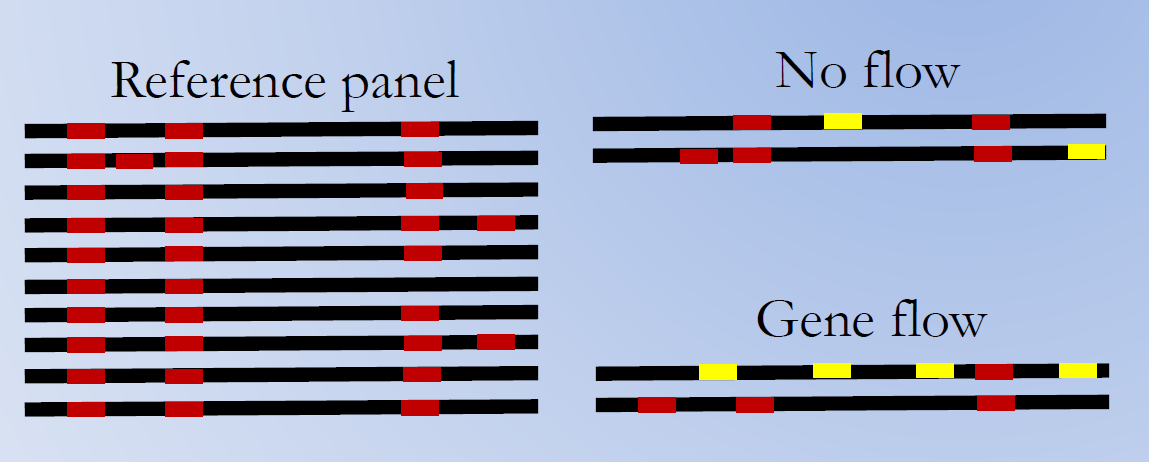

**sstar** is a tool to use this statistic on a set of genomes (here is the paper: https://doi.org/10.1093/molbev/msac212). It is a python package to use S* for getting introgressed pieces of the genome.

To do this, several steps are performed.

* First, the S* statistic is calculated in small windows along the genome.

* Second, based on a demographic model, the expected S* scores for this population.

* Third, significance is assessed.

* Fourth, the introgressed fragments are defined.

* An optional fifth step, in case you have one or two possible source genomes, is to calculate the match to these sources.


## Calculating S* scores

The scores can be calculated with the function `sstar score`, and defined lists of individuals that are the "Reference panel" (no introgression) and the "Target panel" (potentially introgression). Check the two lists, then apply the function.

```
sstar score --vcf testset.filtered.nomis.vcf.gz --ref ref.ind.list --tgt tgt.ind.list --output test.score.results
```

This is the most basic command, but there are parameters to change. Ask for help!

Now we inspect the score.results table, what is there?


## Using a demographic model to know what is significant

This uses the program `ms` to simulate data. We know that the prophecy claims "[Thou shalt use msprime!](https://twitter.com/vsbuffalo/status/1358969320244531205)", but S* was developed with `ms` for some of its features. At some point in the future, this is likely to change, and I hope you won't need `ms`. But for now we can and need to use it within the sstar package as is.

The good thing is that things are already designed in a nice way: we can put in demographic models in a human-readable format. I just downloaded the human model from here: https://popsim-consortium.github.io/demes-spec-docs/main/gallery.html to go ahead with this part.

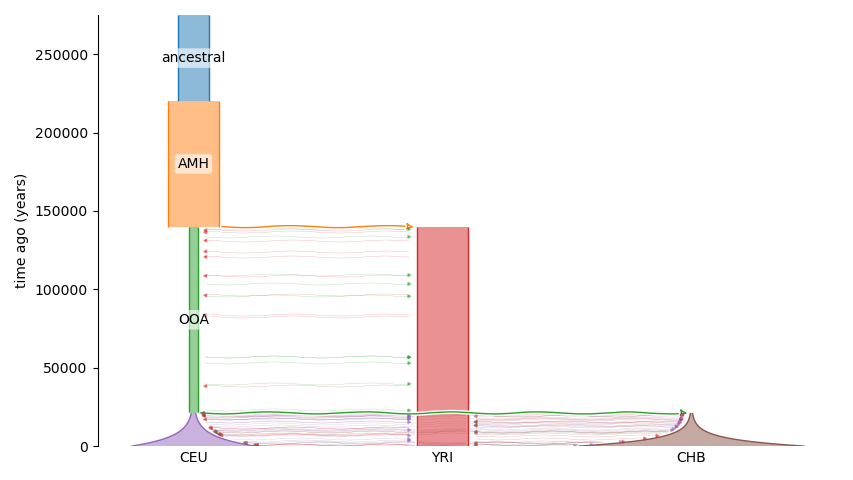

```
description: The Gutenkunst et al. (2009) OOA model.
doi:
- https://doi.org/10.1371/journal.pgen.1000695
time_units: years
generation_time: 25

demes:
- name: ancestral
  description: Equilibrium/root population
  epochs:
  - {end_time: 220e3, start_size: 7300}
- name: AMH
  description: Anatomically modern humans
  ancestors: [ancestral]
  epochs:
  - {end_time: 140e3, start_size: 12300}
- name: OOA
  description: Bottleneck out-of-Africa population
  ancestors: [AMH]
  epochs:
  - {end_time: 21.2e3, start_size: 2100}
- name: YRI
  description: Yoruba in Ibadan, Nigeria
  ancestors: [AMH]
  epochs:
  - start_size: 12300
- name: CEU
  description: Utah Residents (CEPH) with Northern and Western European Ancestry
  ancestors: [OOA]
  epochs:
  - {start_size: 1000, end_size: 29725}
- name: CHB
  description: Han Chinese in Beijing, China
  ancestors: [OOA]
  epochs:
  - {start_size: 510, end_size: 54090}

migrations:
- {demes: [YRI, OOA], rate: 25e-5}
- {demes: [YRI, CEU], rate: 3e-5}
- {demes: [YRI, CHB], rate: 1.9e-5}
- {demes: [CEU, CHB], rate: 9.6e-5}
```


The command you *would* then run is the following:

```
# First: compile the ms program
tar -zxvf ms.tar.gz
cd msdir
gcc -o ms ms.c streec.c rand1.c -lm
cd..

# Second: run sstar to get the data
sstar quantile --model human_model.yaml --ms-dir msdir/ --N0 1000 --nsamp 22 --nreps 20000 --ref-index 1 --ref-size 20 --tgt-index 2 --tgt-size 2 --mut-rate 1e-8 --rec-rate 1e-8 --seq-len 50000 --snp-num-range 10 250 5 --output-dir quantiles --thread 4
```

Since this part takes quite some time (and memory), I prepared the output already. But you can use the commands above to run the actual thing (e.g. if you had a different population setting you want to look at)!

Let's inspect the file `quantile.summary.txt`


## Applying the threshold

Now, we have empirically measured S* in our individuals, and an idea what to expect given the history of humans. It's also good to have a recombination map to be able to differentiate between haplotypes.

In this example, we use the calculated scores with the precalculated simulated expectations, and a recombination map.

```
sstar threshold --score test.score.results --sim-data quantile.summary.txt --recomb-map plink.chr21.GRCh37.map --quantile 0.99 --output sstar.threshold.results
```

Now we inspect the output file.


## Get the introgressed tracts

So, now let's see how much these fragments match the Neanderthal genome.

```
sstar tract --threshold sstar.threshold.results --output-prefix sstar.test
```


## Calculating the match to a source population

Then, we can calculate the match to the Neanderthal genome (i.e. how many of the SNPs do agree with the Neanderthal).

sstar matchrate --vcf testset.filtered.nomis.vcf.gz  --ref ref.ind.list --tgt tgt.ind.list --src altai.list --score sstar.threshold.results --output altai.match.rate.results
